## Analysis of PLIER latent space representations vs. other methods

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import config as cfg
from scripts import cca_core

In [2]:
z_dims = [10, 20, 50, 100, 200]
models_dir = os.path.join(cfg.models_dir, 'canonical_pathways', 'ensemble_z_matrices')
df = None
for z_dim in z_dims:
    weights_pattern = os.path.join(os.path.abspath(models_dir),
                                   'components_{}'.format(z_dim),
                                   '*_weight_matrix.tsv.gz')
    for fname in glob.glob(weights_pattern):
        short_fname = os.path.split(fname)[-1]
        algorithm = short_fname.split('_')[0]
        seed = int(short_fname.split('_')[1])
        signal = ('shuffled' if 'shuffled' in short_fname else 'signal')
        weights = pd.read_csv(fname, sep='\t').to_numpy()
        num_zeros = np.count_nonzero(weights==0)
        sparsity = num_zeros / weights.size
        weights_df = pd.DataFrame({
            'algorithm': [algorithm],
            'z_dim': [z_dim],
            'signal': [signal],
            'seed': [seed],
            'num_zeros': [num_zeros],
            'sparsity': [sparsity]
        })
        if df is not None:
            df = pd.concat((df, weights_df))
        else:
            df = weights_df
df.reset_index(inplace=True)
df.head()

,index,algorithm,z_dim,signal,seed,num_zeros,sparsity
0,0,nmf,10,signal,259178,20601,0.257480
1,0,pca,10,shuffled,131932,0,0.000000
2,0,plier,10,signal,259178,21047,0.559166
3,0,plier,10,signal,131932,21138,0.561583
4,0,nmf,10,shuffled,671155,20801,0.259980


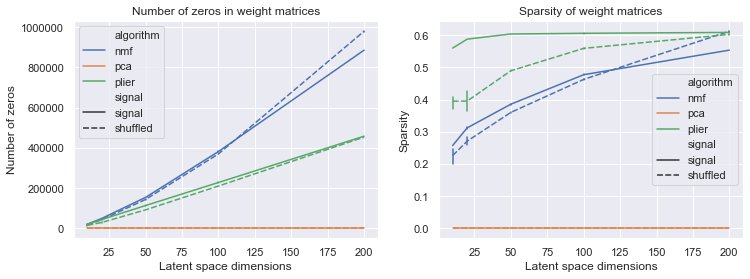

In [3]:
sns.set()
fig, axarr = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
sns.lineplot(data=df, x='z_dim', y='num_zeros', hue='algorithm',
             style='signal', err_style='bars', ax=axarr[0])
axarr[0].set_title('Number of zeros in weight matrices')
axarr[0].set_xlabel('Latent space dimensions')
axarr[0].set_ylabel('Number of zeros')
sns.lineplot(data=df, x='z_dim', y='sparsity', hue='algorithm',
             style='signal', err_style='bars', ax=axarr[1])
axarr[1].set_title('Sparsity of weight matrices')
axarr[1].set_xlabel('Latent space dimensions')
axarr[1].set_ylabel('Sparsity')
# TODO: legend below plots
plt.show()

In [43]:
models_map = {
    'pca': os.path.abspath(models_dir),
    'nmf': os.path.abspath(models_dir),
    'plier_canonical': os.path.abspath(models_dir),
    'plier_oncogenic': os.path.abspath(os.path.join(cfg.models_dir, 'oncogenic_pathways', 'ensemble_z_matrices')),
    'plier_random': os.path.abspath(os.path.join(cfg.models_dir, 'random_pathways', 'ensemble_z_matrices'))
}

def get_overlap_cols_from_plier(models_dirs):
    # TODO: move to latent_space_utilities file eventually, or something like that
    genesets = []
    for m_dir in models_dirs:
        plier_pattern = os.path.join(m_dir,
                                     'components_10',
                                     'plier_*_weight_matrix.tsv.gz')
        fnames = glob.glob(plier_pattern)
        genesets.append(set(pd.read_csv(fnames[0], sep='\t', index_col=0).columns.values))
    return sorted(list(genesets[0].intersection(*genesets[1:])))

def get_overlap_cols_from_files(f1, f2):
    f1_names = set(pd.read_csv(f1, sep='\t', index_col=0).columns.values)
    f2_names = set(pd.read_csv(f2, sep='\t', index_col=0).columns.values)
    return sorted(list(f1_names.intersection(f2_names)))

plier_cols = get_overlap_cols_from_plier(models_map.values())
print(plier_cols[:5])
print(len(plier_cols))

fcols = get_overlap_cols_from_files(
    '/home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices/components_10/plier_259178_weight_matrix.tsv.gz',
    '/home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices/components_10/nmf_259178_weight_matrix.tsv.gz'
)
print(fcols[:5])
print(len(fcols))

['100', '1000', '10000', '10007', '10013']
2594
['100', '1000', '10000', '10006', '10007']
3763


In [45]:
# use SVCCA to visualize weight stability (up to affine transform) across algorithms
# note that we subset all of the weight arrays to the set of genes PLIER uses
# (results may be different if we don't do that for other algorithms)

overlap = True

import itertools
models_map = {
    'pca': os.path.abspath(models_dir),
    'nmf': os.path.abspath(models_dir),
    'plier_canonical': os.path.abspath(models_dir),
    'plier_oncogenic': os.path.abspath(os.path.join(cfg.models_dir, 'oncogenic_pathways', 'ensemble_z_matrices')),
    'plier_random': os.path.abspath(os.path.join(cfg.models_dir, 'random_pathways', 'ensemble_z_matrices'))
}
algorithms = list(models_map.keys())
avg_cca_mtx = {z_dim: np.zeros((len(algorithms), len(algorithms))) for z_dim in z_dims}

def get_matrices_from_files(files, gene_subset, shuffled=False):
    # option 1: get gene subset from overlap of PLIER oncogenic and PLIER random
    #           (this is only ~2500 genes total)
    # option 2: get gene subset from overlap of each pairwise combination of methods
    #           (thus some methods might be compared on different genes than others)
    mtxs, filenames = [], []
    if shuffled:
        files = [f for f in files if 'shuffled' in f]
    else:
        files = [f for f in files if 'shuffled' not in f]
    for f in files:
        mtxs.append(pd.read_csv(f, sep='\t', header=0, index_col=0)[gene_subset])
        filenames.append(f)
    return (mtxs, files)

for z_dim in z_dims:
    for alg1, alg2 in itertools.combinations_with_replacement(algorithms, 2):
        print(alg1, alg2)
        print(models_map[alg1], models_map[alg2])
        i1, i2 = algorithms.index(alg1), algorithms.index(alg2)
        cca_values = []
        alg1_pattern = os.path.join(models_map[alg1],
                                    'components_{}'.format(z_dim),
                                    '{}_*_weight_matrix.tsv.gz'.format(alg1.split('_')[0]))
        alg2_pattern = os.path.join(models_map[alg2],
                                    'components_{}'.format(z_dim),
                                    '{}_*_weight_matrix.tsv.gz'.format(alg2.split('_')[0]))
        alg1_files = glob.glob(alg1_pattern)
        alg2_files = glob.glob(alg2_pattern)
        if overlap:
            overlap_cols = get_overlap_cols_from_files(alg1_files[0], alg2_files[0])
        else:
            overlap_cols = get_overlap_cols_from_plier(list(set(models_map.values())))
        (alg1_matrices, alg1_files) = get_matrices_from_files(alg1_files, overlap_cols)
        (alg2_matrices, alg2_files) = get_matrices_from_files(alg2_files, overlap_cols)
        for s1, s2 in itertools.product(range(len(alg1_matrices)), range(len(alg2_matrices))):
            cca_result = cca_core.robust_cca_similarity(alg1_matrices[s1], alg2_matrices[s2], verbose=False)
            cca_values.append(np.mean(cca_result['mean']))
        avg_cca_mtx[z_dim][i1, i2] = np.mean(cca_values)
        avg_cca_mtx[z_dim][i2, i1] = avg_cca_mtx[z_dim][i1, i2]
        
print(avg_cca_mtx[100])

pca pca
/home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices /home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices
pca nmf
/home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices /home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices
pca plier_canonical
/home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices /home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices
pca plier_oncogenic
/home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices /home/jake/research/netreg/models/oncogenic_pathways/ensemble_z_matrices
pca plier_random
/home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices /home/jake/research/netreg/models/random_pathways/ensemble_z_matrices
nmf nmf
/home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices /home/jake/research/netreg/models/canonical_pathways/ensemble_z_matrices
nmf plier_canonical
/home/jake/research/netreg

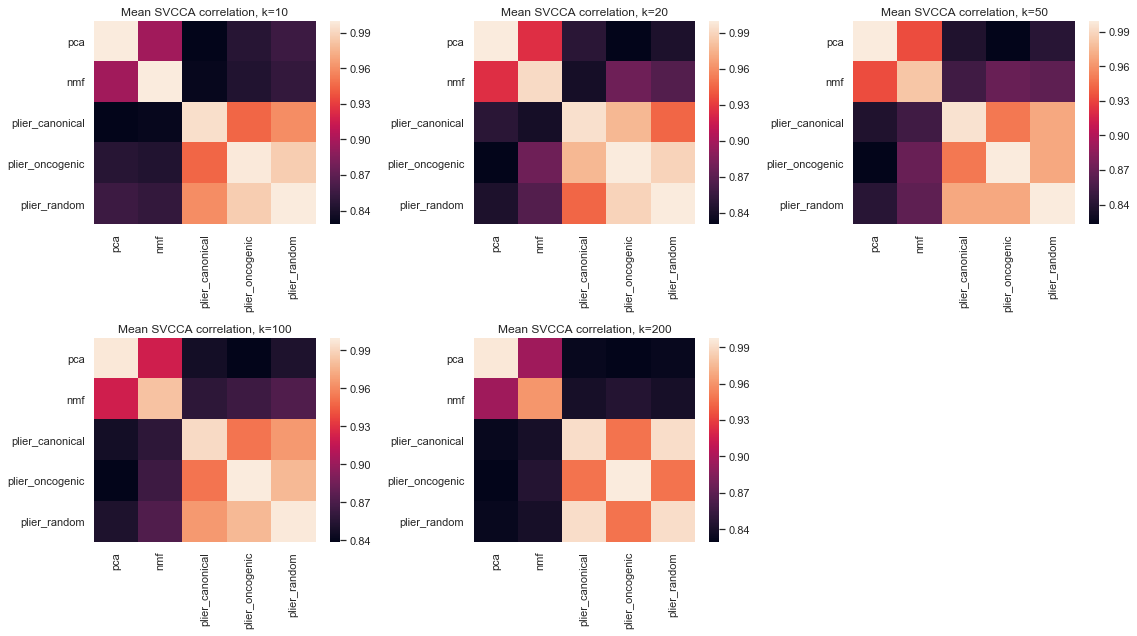

In [49]:
sns.set()
fig, axarr = plt.subplots(2, 3)
fig.set_figwidth(16)
fig.set_figheight(9)
fig.delaxes(axarr[1][2])

for ix, z_dim in enumerate(z_dims):
    ax = axarr[ix // 3, ix % 3]
    df = pd.DataFrame(data=avg_cca_mtx[z_dim], index=algorithms, columns=algorithms)
    sns.heatmap(df, ax=ax)
    ax.set_title('Mean SVCCA correlation, k={}'.format(z_dim))
plt.tight_layout()